In [1]:
import sys, os
ROOT = os.path.abspath("..")   # go up one directory from notebooks/
if ROOT not in sys.path:
    sys.path.append(ROOT)

print(ROOT)  


c:\Users\tdiks\Documents\PINN


In [2]:
from src2.networks import get_all_networks
from src2.config import CONFIG

from src2.sampling import (
    sample_domain_points,
    sample_top_surface,
    sample_interface,
    sample_far_field
)

from src2.losses import total_loss

from src2.pde_residuals import (
    residual_layer_coupled,
    residual_halfspace
)

from src2.boundary_conditions import (
    top_surface_bc,
    interface_layer_halfspace,
    halfspace_far_field_bc
)


# — Torch + Device

In [3]:
import torch
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


# Build-Models

In [4]:
model_layer, model_half = get_all_networks()

model_layer.to(DEVICE)
model_half.to(DEVICE)


PINN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): Tanh()
    (16): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Load Config & Geometry

In [5]:
geom = CONFIG["GEOMETRY"]

params_layer = CONFIG["LAYER"]
params_half  = CONFIG["HALFSPACE"]
dispersion = []   # <-- DEFINE DISPERSION HERE


# Define trainable phase velocity (c)

In [6]:
c = torch.nn.Parameter(
    torch.tensor(
        (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
        device=DEVICE
    )
)


# Optimizer

In [7]:
optimizer = optim.Adam(
    list(model_layer.parameters()) +
    list(model_half.parameters()) +
    [c],
    lr=1e-3
)


# Training Loop (Simple + Transparent)

In [8]:
dispersion = []   # <-- define once, BEFORE this block

# Training Loop (Dispersion)
k_values = torch.linspace(
    CONFIG["GEOMETRY"]["k_min"],
    CONFIG["GEOMETRY"]["k_max"],
    CONFIG["GEOMETRY"]["num_k"]
)

for k in k_values:

    # Build-Models
    model_layer, model_half = get_all_networks()
    model_layer.to(DEVICE)
    model_half.to(DEVICE)

    # Define trainable phase velocity (c)
    c = torch.nn.Parameter(
        torch.tensor(
            (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
            device=DEVICE
        )
    )

    optimizer = optim.Adam(
        list(model_layer.parameters()) +
        list(model_half.parameters()) +
        [c],
        lr=1e-3
    )

    # -------- INNER TRAINING LOOP --------
    for epoch in range(1, 5):

        z_layer, z_half = sample_domain_points(3000, geom)
        z_top = sample_top_surface(1000, geom)
        z_int = sample_interface(1000)
        z_far = sample_far_field(1000, geom)

        optimizer.zero_grad()

        loss, logs = total_loss(
            model_layer,
            model_half,
            z_layer,
            z_half,
            z_top,
            z_int,
            z_far,
            params_layer,
            params_half,
            k.item()* geom["H"],   # <-- correct
            c,
            w_pde=1.0,
            w_bc=0.1,
            w_int=0.01,
            w_far=0.001,
        )
    

        loss.backward()
        optimizer.step()

        if epoch % 2 == 0:
            print(
                f"k={k.item():.2f} | "
                f"Epoch {epoch} | "
                f"Loss={loss.item():.3e} |"
                f"PDE={logs['pde']:.2e} | "
                f"BC={logs['bc_top']:.2e} | "
                f"INT={logs['interface']:.2e} | "
                f"FAR={logs['far']:.2e}"
            )

    
    dispersion.append([k.item(), c.item()])


c:\Users\tdiks\Documents\PINN\src2\losses.py:181: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  mono_penalty = monotonicity_penalty(torch.tensor([c]))


k=0.10 | Epoch 2 | Loss=2.683e+12 |PDE=2.66e+12 | BC=1.31e+11 | INT=7.32e+11 | FAR=7.41e-08
k=0.10 | Epoch 4 | Loss=7.203e+10 |PDE=6.94e+10 | BC=1.73e+10 | INT=9.16e+10 | FAR=9.33e-07
k=0.23 | Epoch 2 | Loss=1.234e+12 |PDE=1.14e+12 | BC=1.21e+10 | INT=9.53e+12 | FAR=9.81e-07
k=0.23 | Epoch 4 | Loss=2.113e+11 |PDE=2.05e+11 | BC=5.17e+09 | INT=5.49e+11 | FAR=1.23e-08
k=0.35 | Epoch 2 | Loss=7.540e+12 |PDE=7.29e+12 | BC=1.72e+11 | INT=2.30e+13 | FAR=1.05e-06
k=0.35 | Epoch 4 | Loss=3.462e+11 |PDE=3.44e+11 | BC=7.44e+09 | INT=1.49e+11 | FAR=4.82e-08
k=0.48 | Epoch 2 | Loss=1.084e+13 |PDE=1.08e+13 | BC=4.70e+10 | INT=3.39e+11 | FAR=1.40e-06
k=0.48 | Epoch 4 | Loss=8.663e+11 |PDE=8.64e+11 | BC=1.37e+10 | INT=8.78e+10 | FAR=8.15e-08
k=0.60 | Epoch 2 | Loss=5.527e+12 |PDE=5.49e+12 | BC=4.42e+10 | INT=3.76e+12 | FAR=6.26e-08
k=0.60 | Epoch 4 | Loss=5.185e+11 |PDE=5.16e+11 | BC=3.28e+09 | INT=1.83e+11 | FAR=1.15e-08
k=0.73 | Epoch 2 | Loss=6.019e+13 |PDE=6.01e+13 | BC=1.71e+10 | INT=6.32e+12 | F

In [9]:
torch.save({
    "model_layer": model_layer.state_dict(),
    "model_half": model_half.state_dict(),
    "c": c.detach().cpu()
}, "dispersion_pinn.pth")

print("Model saved.")


Model saved.


Choose time & y-location

In [10]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

H = geom["H"]   # layer thickness
L = geom["L"]   # half-space depth


Create a point in each layer

In [11]:
# z-grid for plotting / post-processing

z_layer = torch.linspace(-H, 0.0, 200).reshape(-1, 1).to(DEVICE)
z_half  = torch.linspace(0.0, L, 200).reshape(-1, 1).to(DEVICE)


Feed to model

In [12]:
with torch.no_grad():

    scale = 1e-2
# Layer (complex amplitude)   
    
V_layer = model_layer(z_layer)
V_R = scale * V_layer[:, 0:1]
V_I = scale * V_layer[:, 1:2]
# Half-space (real amplitude)
V_half = scale * model_half(z_half)



Plot Disperion curves


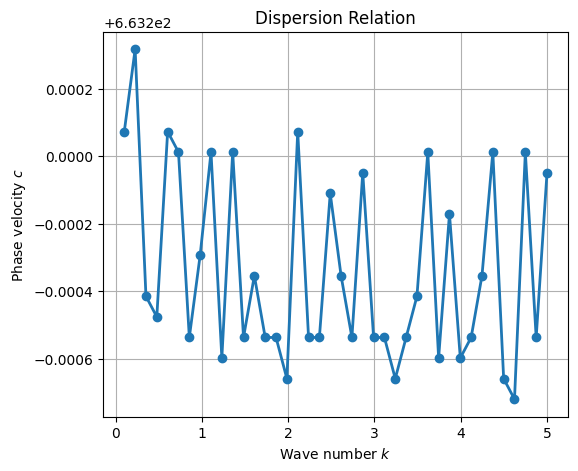

In [13]:
import matplotlib.pyplot as plt
import torch

# dispersion: shape (N, 2) → [k, c]
dispersion = torch.tensor(dispersion)
# dispersion: shape (N, 2) → [k, c]
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]


plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)

plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("Dispersion Relation")
plt.grid(True)

plt.show()


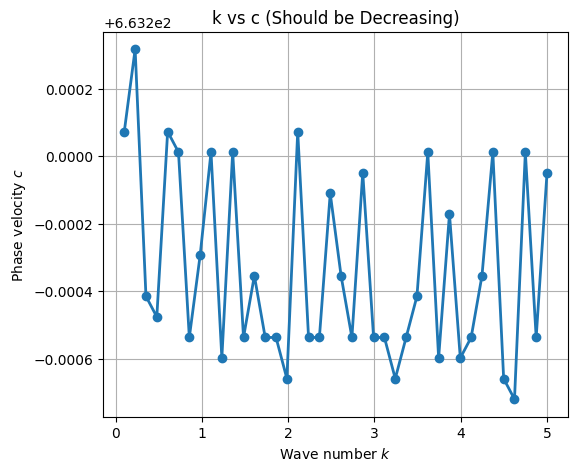

Is c monotonically decreasing with k? False


In [14]:
# Plot k vs c and check monotonicity (c should decrease as k increases)
import matplotlib.pyplot as plt
import torch

# Convert dispersion to tensor for analysis
if isinstance(dispersion, list):
    dispersion_tensor = torch.tensor(dispersion)
else:
    dispersion_tensor = dispersion

k_vals = dispersion_tensor[:, 0]
c_vals = dispersion_tensor[:, 1]

# Plot k vs c
plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)
plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("k vs c (Should be Decreasing)")
plt.grid(True)
plt.show()

# Check if c is monotonically decreasing with k
is_decreasing = torch.all(c_vals[:-1] >= c_vals[1:])
print("Is c monotonically decreasing with k?", is_decreasing.item())

In [15]:
k_vals

tensor([0.1000, 0.2256, 0.3513, 0.4769, 0.6026, 0.7282, 0.8538, 0.9795, 1.1051,
        1.2308, 1.3564, 1.4821, 1.6077, 1.7333, 1.8590, 1.9846, 2.1103, 2.2359,
        2.3615, 2.4872, 2.6128, 2.7385, 2.8641, 2.9897, 3.1154, 3.2410, 3.3667,
        3.4923, 3.6179, 3.7436, 3.8692, 3.9949, 4.1205, 4.2462, 4.3718, 4.4974,
        4.6231, 4.7487, 4.8744, 5.0000])

In [ ]:
c_vals

tensor([663.2001, 663.2003, 663.1996, 663.1995, 663.2001, 663.2000, 663.1995,
        663.1997, 663.2000, 663.1994, 663.2000, 663.1995, 663.1996, 663.1995,
        663.1995, 663.1993, 663.2001, 663.1995, 663.1995, 663.1999, 663.1996,
        663.1995, 663.2000, 663.1995, 663.1995, 663.1993, 663.1995, 663.1996,
        663.2000, 663.1994, 663.1998, 663.1994, 663.1995, 663.1996, 663.2000,
        663.1993, 663.1993, 663.2000, 663.1995, 663.2000])

: 